# Модуль А. Анализ и предобработка данных

## Импорт библиотек

In [15]:
# для преобразований фотографий
import cv2
from PIL import Image

# для работы с файловой системой
import os
import shutil

# модуль с более удобными словарями
from collections import defaultdict

# для разбиения на выборки
from sklearn.model_selection import train_test_split

# для визуализации
import matplotlib.pyplot as plt

# для работы с архивами
from zipfile import ZipFile

# для отслеживания времени
import time

# для прогресс баров
from tqdm import tqdm

# для вычисления хэша 
import hashlib

In [2]:
# получаем корневой путь
main_dir = os.getcwd()[:-8]
print("Текущая корневая директория:", main_dir)

Текущая корневая директория: d:\Helper\MLBazyak\chemp\face_recognitionV2


## Загрузка данных

в качестве данных, я получил архив с названием `Датасеты25.zip`. для начала работы, нужно их разархивировать.

Используя утилиту `WinRAR` я разархивировал папку `Датасеты25` в директорию `Data\`, а также переименовал папку на `Data25`, так как с русскими путями часто бывают проблемы. Папку для `MacOS` я решил не использовать

In [3]:
# путь к основной папке с данными
data_path = os.path.join(main_dir, r'Data\Data25')
# список всех представленных папок (датасетов)
datas_list = os.listdir(data_path)
# логирование
print(f'Папка с данными: {data_path}')
print(f'Всего предлагаемых датасетов: {len(datas_list)}')
print(f'Представленные папки: {datas_list}')

Папка с данными: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25
Всего предлагаемых датасетов: 3
Представленные папки: ['archive', 'archive-3', 'faces']


## Датасет 1: archive

In [6]:
# получаем путь к первому датасету (archive)
path_to_data1 = os.path.join(data_path, datas_list[0])
# логирование
print(f'Путь к первому датасету: {path_to_data1}')

Путь к первому датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive


В датасете представлены `2` основные папки - просто с фотографиями с лицами, и с кропами лиц тех же самых фотографий 

In [7]:
print(os.listdir(path_to_data1)) # 2 основные папки, и файл с логами
# получааем путь к папке с кропами
extracted_face_data1 = os.path.join(path_to_data1, r'Extracted Faces\Extracted Faces')
print(f'Путь к папке с кропами: {extracted_face_data1}')
# получаем путь к папке с целыми фото
face_data1 = os.path.join(path_to_data1, r'Face Data\Face Dataset')
print(f'Путь к папке с целыми фото: {face_data1}')

['Extracted Faces', 'Face Data']
Путь к папке с кропами: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Extracted Faces\Extracted Faces
Путь к папке с целыми фото: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Face Data\Face Dataset


проанализируем этот датасет:

Датасет с кропами: всего 1324 папок


Датасет с кропами: сбор данных..: 100%|██████████| 1324/1324 [00:00<00:00, 13244.84folder/s]

Датасет с кропами: всего 6107 фотографий


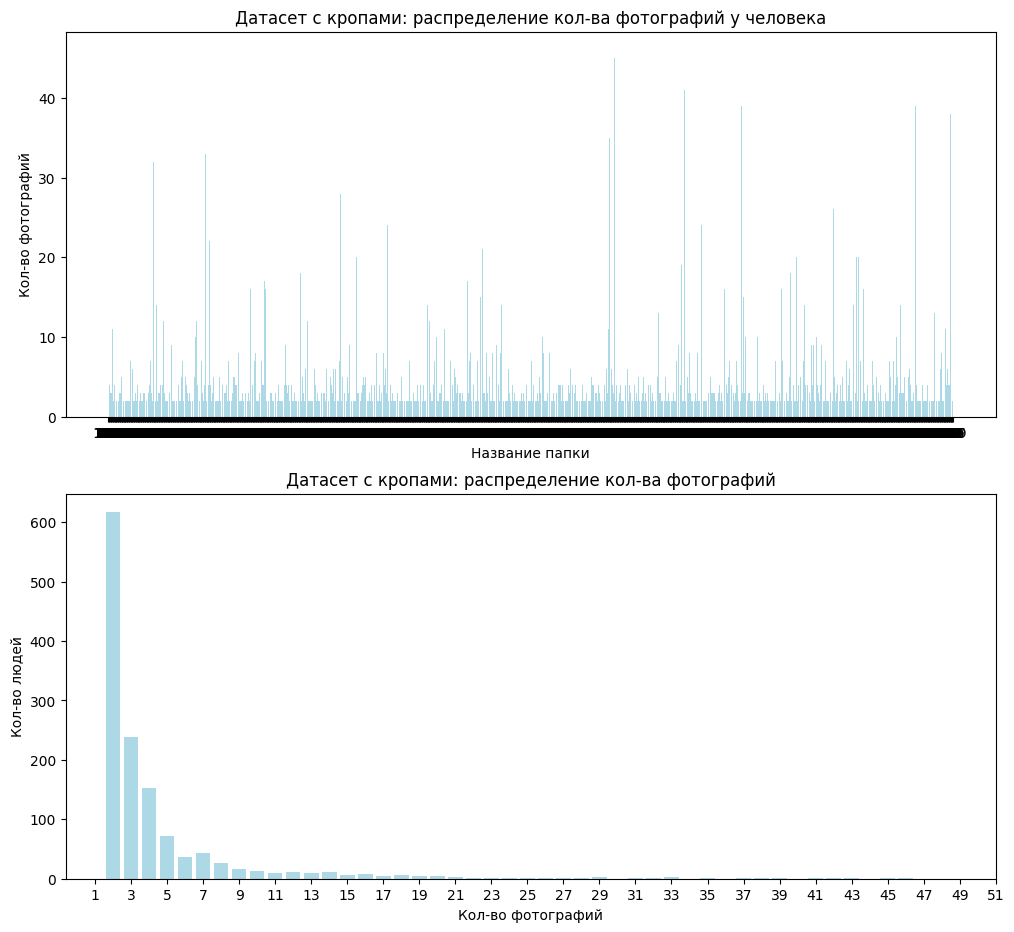

Максимальное кол-во: 46, номер папки - 1588
Топ 5 минимальных по заполненности значений у папки: [2, 3, 4, 5, 6]
-----------------------------------
Датасет с фотографиями: всего 1680 папок


Датасет с фотографиями: сбор данных..: 100%|██████████| 1680/1680 [00:00<00:00, 29676.80folder/s]

Датасет с фотографиями: всего 8204 фотографий


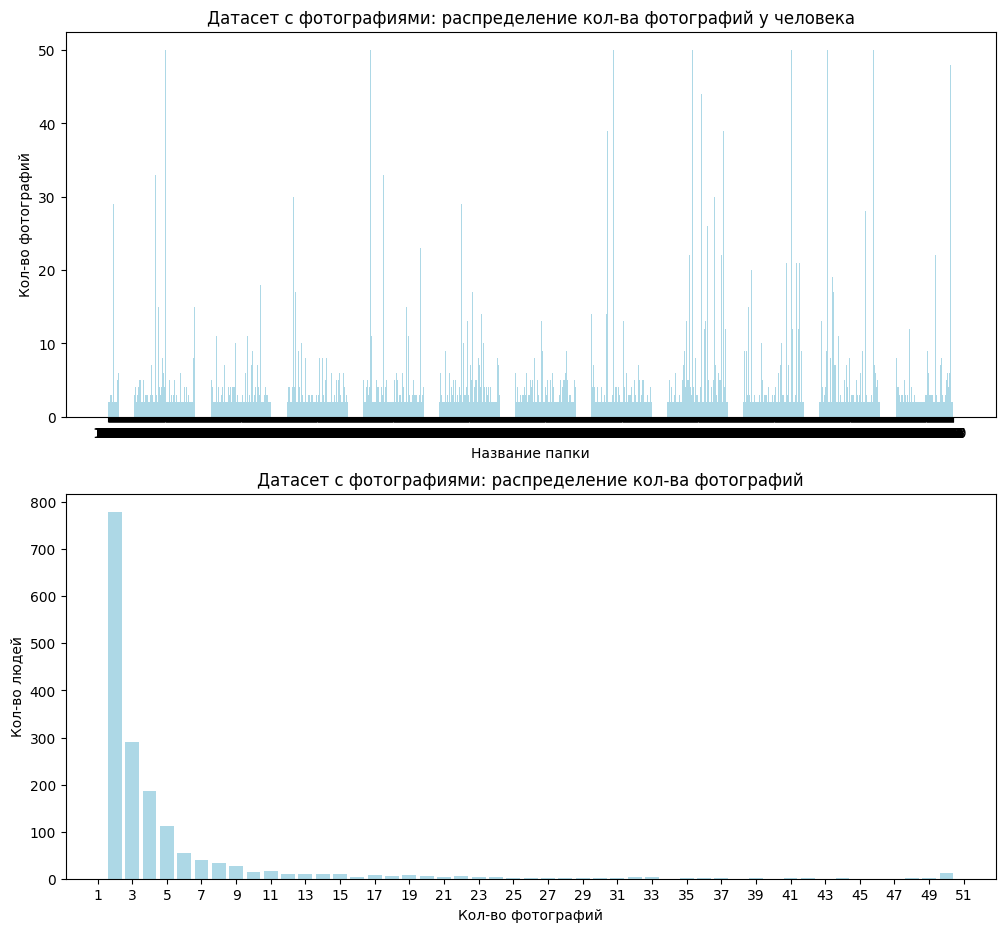

Максимальное кол-во: 50, номер папки - 110
Топ 5 минимальных по заполненности значений у папки: [2, 3, 4, 5, 6]
-----------------------------------


In [16]:
# список с именами датасетов
data_names = ['Датасет с кропами', 'Датасет с фотографиями']
datas = [extracted_face_data1, face_data1]

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # логирование
    print(f'{data_names[i]}: всего {len(os.listdir(datas[i]))} папок')
    # счетчик фотографий
    counter = 0
    # 
    max_name, max_value = 0,0
    # словарь для статистики
    nums_stats = defaultdict(int)
    value_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(data), desc=f'{data_names[i]}: сбор данных..', unit='folder'):
        # получаем путь к папке
        folder_path = os.path.join(datas[i], folder)
        # обновляем счетчик и вводим статистику в словарь
        img_nums = len(os.listdir(folder_path))
        #
        if img_nums > max_value:
            max_value=img_nums
            max_name=folder

        counter+=img_nums
        
        nums_stats[folder]=img_nums
        value_stats[img_nums]+=1

    print(f'{data_names[i]}: всего {counter} фотографий')

    # парсим получившийся словарь
    nums = nums_stats.values()
    folders = nums_stats.keys()

    fig, ax = plt.subplots(2,1,figsize=(12,11))
    # визуализируем результат
    ax[0].bar(folders, nums, color='lightblue')
    ax[0].set_title(f'{data_names[i]}: распределение кол-ва фотографий у человека')
    ax[0].set_xlabel('Название папки')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    value = value_stats.keys()
    # визуализируем результат
    ax[1].bar(value, counts, color='lightblue')
    ax[1].set_title(f'{data_names[i]}: распределение кол-ва фотографий')
    ax[1].set_xlabel('Кол-во фотографий')
    ax[1].set_ylabel('Кол-во людей')
    ax[1].set_xticks(range(1,52,2))
    plt.show()
    # логирование
    print(f'Максимальное кол-во: {max_value}, номер папки - {max_name}')
    print('Топ 5 минимальных по заполненности значений у папки:', list(set(list(value)))[0:5])
    print('-----------------------------------')



**По результатам анализа можно заметить что:**

- в каждой папке есть минимум 2 фотографии (нет пропусков в датасете)
- макс кол-во фотографий у датасета с кропами: `46`
- макс кол-во фотографий у датасета с целыми фотографиями: `50`
- у большинства людей из папок по 2 фотографии
- в датасете с кропами на `356` папок меньше, чем в полных фотографиях (от них надо избавиться)

Проверка на формат фотографий в датасете:

Датасет с кропами: анализ..: 100%|██████████| 1324/1324 [00:01<00:00, 1321.01folder/s]


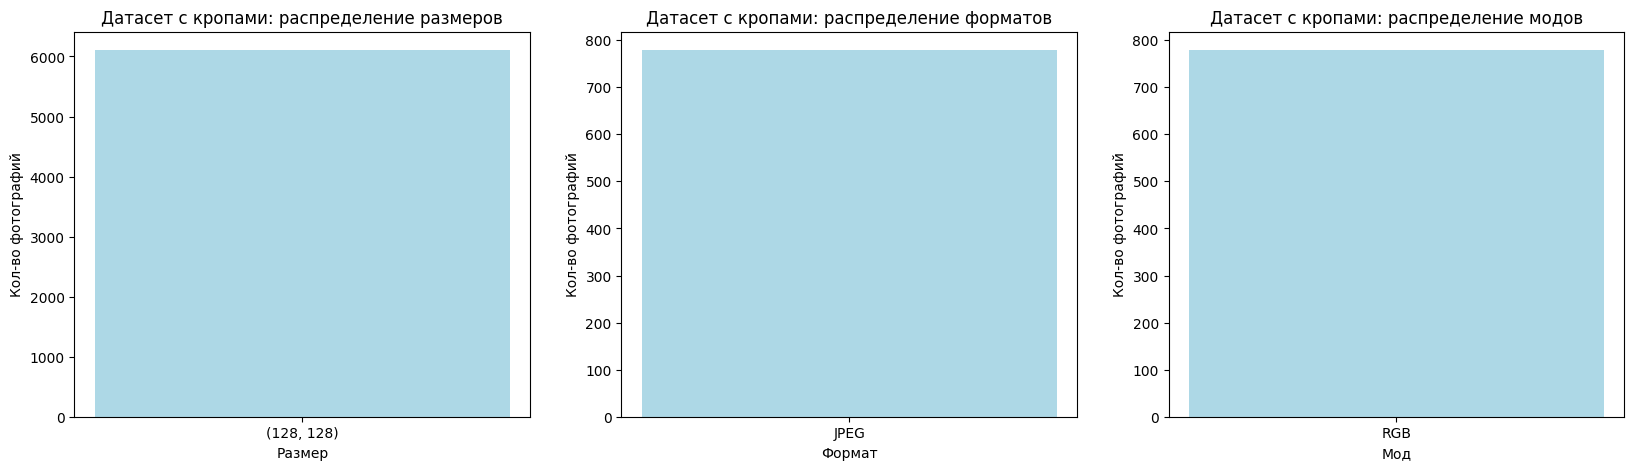

Датасет с фотографиями: анализ..: 100%|██████████| 1680/1680 [00:01<00:00, 1442.02folder/s]


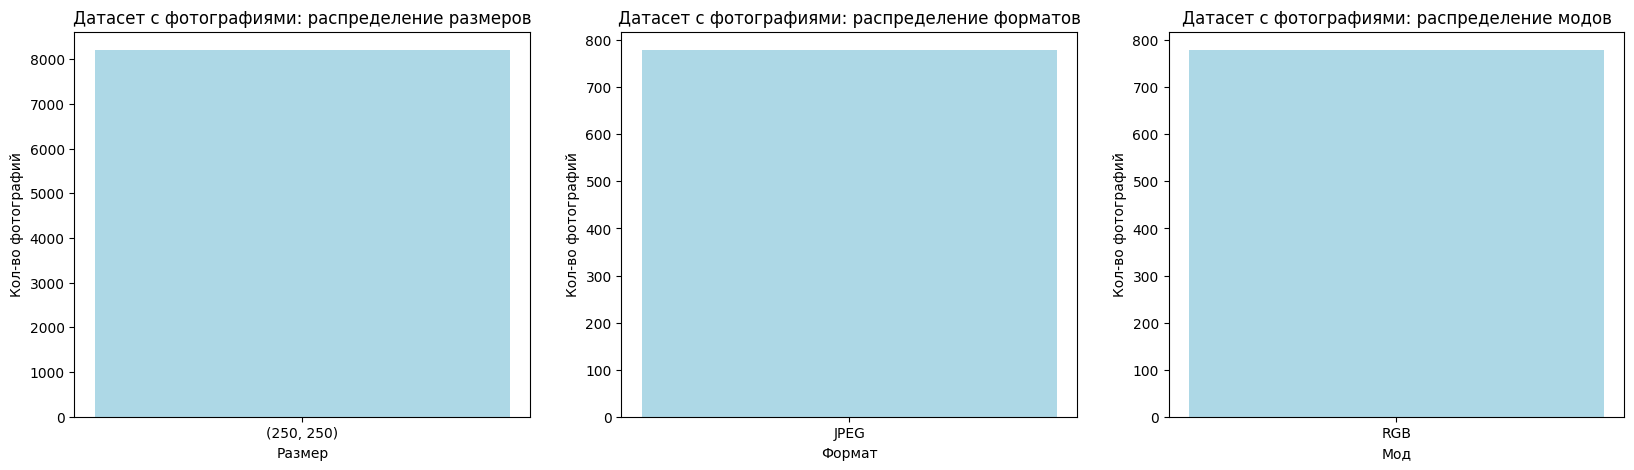

In [12]:
# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]

    # словари для статистики
    mode_stats = defaultdict(int)
    size_stats = defaultdict(int)
    format_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(datas[i]), desc=f'{data_names[i]}: анализ..', unit='folder'):
        # путь к папке
        folder_path = os.path.join(datas[i], folder)
        # проходимся по каждой фотографии в папке
        for img in os.listdir(folder_path):
            # путь к фотографии
            img_path = os.path.join(folder_path, img)
            # открываем фотографию испльзуя pillow
            img = Image.open(img_path)
            # обновляем словари
            size_stats[f'{img.size}']+=1
            format_stats[img.format]+=1
            mode_stats[img.mode]+=1

    # разбиваем график на несколько
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    # парсим получившийся словарь
    counts = size_stats.values()
    size = size_stats.keys()
    # визуализируем результат
    ax[0].bar(size, counts, color='lightblue')
    ax[0].set_title(f'{data_names[i]}: распределение размеров')
    ax[0].set_xlabel('Размер')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    format_ = format_stats.keys()
    # визуализируем результат
    ax[1].bar(format_, counts, color='lightblue')
    ax[1].set_title(f'{data_names[i]}: распределение форматов')
    ax[1].set_xlabel('Формат')
    ax[1].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    mode = mode_stats.keys()
    # визуализируем результат
    ax[2].bar(mode, counts, color='lightblue')
    ax[2].set_title(f'{data_names[i]}: распределение модов')
    ax[2].set_xlabel('Мод')
    ax[2].set_ylabel('Кол-во фотографий')

    plt.show()    

Можно заметить, что `размер`, `мод` и `формат` у всех изображений на каждой папке одинаковый, так что датасеты приведены к стандартизированному формату

Проверим датасет на дубликаты:

In [ ]:
# функция для вычисления хэша
def calculate_hash(image_path):
    '''Вычисляет хеш изображения.'''
    # открываем фотографию
    with open(image_path, "rb") as f:
        # извлекаем хэш
        return hashlib.md5(f.read()).hexdigest()

In [ ]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(data), desc=f'{data_names[i]}: поиск дубликатов..', unit='folder'):
        # путь к папке
        folder_path = os.path.join(datas[i], folder)
        # проходимся по каждой фотографии в папке
        for img in os.listdir(folder_path):
            # путь к фотографии
            img_path = os.path.join(folder_path, img)
            # вычисляем хэш
            image_hash = calculate_hash(img_path)
            # првоеряем, есть ли такой хэш в словаре
            if image_hash in hash_dict:
                # если да, то обновляем список с дубликатами
                duplicates.append((img_path, hash_dict[image_hash]))
            # если нет, то добавляем хэш в словарь
            else:
                hash_dict[image_hash] = img_path
    # если дубликаты есть
    if duplicates:
        print(f'{data_names[i]}: найдены дубликаты')
        for dup in duplicates:
            print(f"Дубликат: {dup[0]} и {dup[1]}")
    # если дубликатов нет
    else:
        print(f'{data_names[i]}: дубликаты не найдены')
    # логирование
    print('Поиск дубликатов закончен')


Датасет с кропами: поиск дубликатов..: 100%|██████████| 1324/1324 [00:00<00:00, 2215.99folder/s]


Датасет с кропами: дубликаты не найдены
Поиск дубликатов закончен


Датасет с фотографиями: поиск дубликатов..: 100%|██████████| 1680/1680 [00:01<00:00, 1462.96folder/s]

Датасет с фотографиями: дубликаты не найдены
Поиск дубликатов закончен


**Дубликаты не были обнаружены**

Датасет с фотографиями: анализ..: 100%|██████████| 1680/1680 [00:01<00:00, 1607.14folder/s]

Дубликаты не найдены.


**Структура данных в наборе:**

    -> archive\     # главная папка
        -> Extracted Faces\Extracted Faces\     # папка с кропнутыми лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография
                -> 1.jpg        # фотография
                
            -> 1\      
                -> 0.jpg
                -> 1.jpg

        -> Face Data\Face Dataset\      # папка с цельными лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография      
                -> 1.jpg        # фотография      

            -> 1\
                -> 0.jpg
                -> 1.jpg

